<a href="https://colab.research.google.com/github/nandini11122004/Analog_automation/blob/main/graph_circuit_lumping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

R2-R3: Parallel
C1-C2: Parallel
R4-R5: Parallel
R6-R7: Parallel
R1-R2: Series
R8-R9: Series


<ipython-input-1-973ef0e7b8e3>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


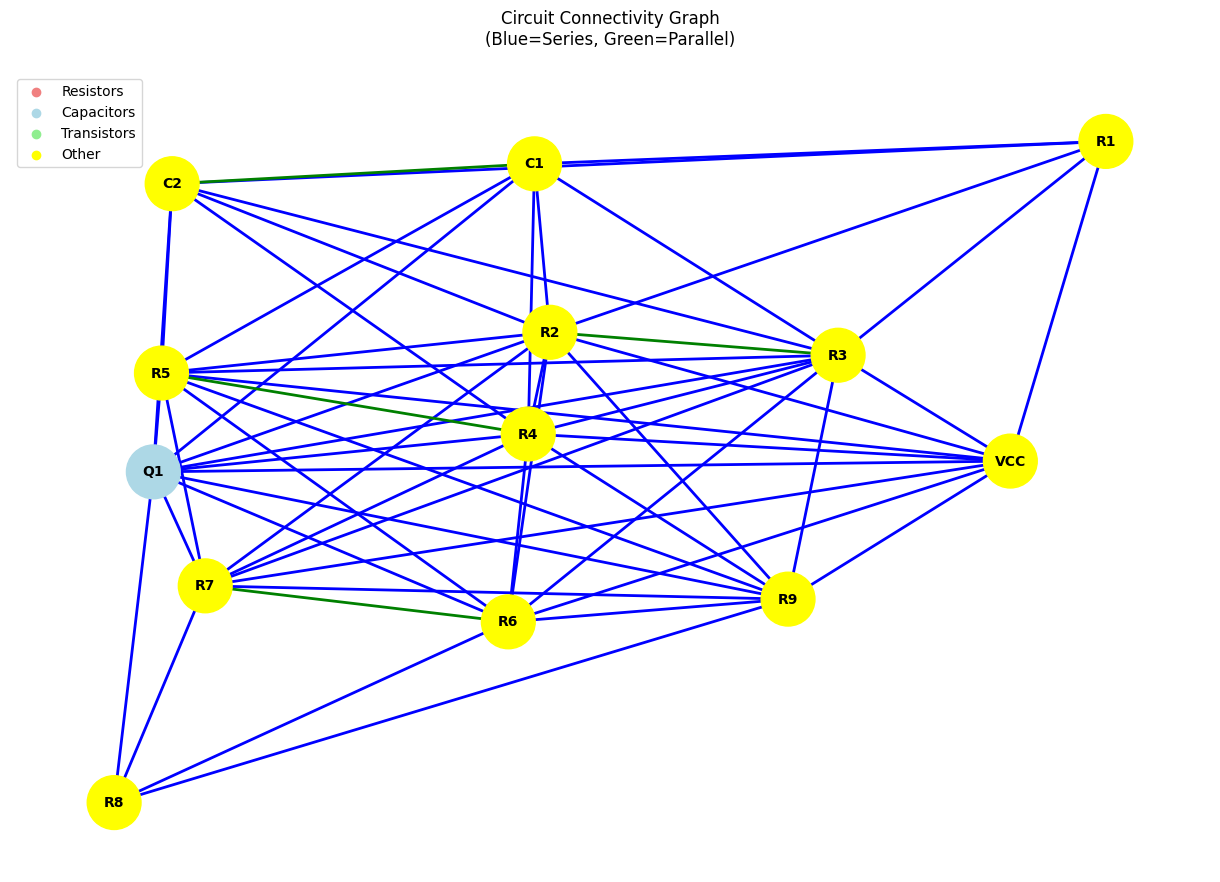

In [ ]:
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

def parse_netlist(netlist):
    components = {}
    node_to_components = defaultdict(set)

    for line in netlist:
        parts = line.strip().split()
        comp = parts[0]

        # Keep all nodes (even "0"), only skip known keywords
        skip_keywords = {'DC', 'SIN'}
        nodes = [n for n in parts[1:-1] if n not in skip_keywords]

        components[comp] = nodes
        for node in nodes:
            node_to_components[node].add(comp)


    return components, node_to_components

def check_connection(comp1, comp2, components, node_to_components):
    nodes1 = set(components[comp1])
    nodes2 = set(components[comp2])
    shared_nodes = nodes1 & nodes2

    # Parallel condition: exactly two shared nodes & both are two-terminal
    if len(shared_nodes) == 2 and len(nodes1) == 2 and len(nodes2) == 2:
        return "Parallel"

    # If they share at least one node, assume series
    elif shared_nodes:
        return "Series"

    return "Neither"

def build_connectivity_graph(components, node_to_components):
    G = nx.Graph()

    # Add all components as nodes
    for comp in components:
        G.add_node(comp, type=components[comp][-1] if components[comp] else '')

    # Connect components and label their connection type
    for node, comps in node_to_components.items():
      comp_list = list(comps)
      for i in range(len(comp_list)):
          for j in range(i + 1, len(comp_list)):
              c1, c2 = comp_list[i], comp_list[j]
              # Only check connection if both components are present
              if c1 in components and c2 in components:
                  conn_type = check_connection(c1, c2, components, node_to_components)
                  G.add_edge(c1, c2, connection=conn_type)


    return G

def draw_connectivity_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=0.5)

    # Color nodes by component type
    node_colors = []
    for node in G.nodes():
        if G.nodes[node]['type'].startswith('R'):
            node_colors.append('lightcoral')
        elif G.nodes[node]['type'].startswith('C'):
            node_colors.append('lightblue')
        elif G.nodes[node]['type'].startswith('Q'):
            node_colors.append('lightgreen')
        else:
            node_colors.append('yellow')

    # Draw with different edge colors for connection types
    edge_colors = []
    for u, v, d in G.edges(data=True):
        if d['connection'] == "Parallel":
            edge_colors.append('green')
        elif d['connection'] == "Series":
            edge_colors.append('blue')
        else:
            edge_colors.append('gray')

    nx.draw(G, pos, with_labels=True, node_size=1500,
            node_color=node_colors, edge_color=edge_colors,
            width=2, font_size=10, font_weight='bold')

    # Add legend
    plt.scatter([], [], c='lightcoral', label='Resistors')
    plt.scatter([], [], c='lightblue', label='Capacitors')
    plt.scatter([], [], c='lightgreen', label='Transistors')
    plt.scatter([], [], c='yellow', label='Other')
    plt.legend()

    plt.title("Circuit Connectivity Graph\n(Blue=Series, Green=Parallel)", pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test Netlist with clear parallel components
test_netlist = [
    "VCC VCC 0 DC 5",
    "R1 VCC A 1k",
    "R2 A 0 2k",
    "R3 A 0 2.2k",  # Parallel with R2
    "C1 A B 10u",
    "C2 A B 10u",   # Parallel with C1
    "R4 B 0 470",
    "R5 B 0 470",   # Parallel with R4
    "Q1 B 0 C NPN",
    "R6 C 0 100",
    "R7 C 0 100",   # Parallel with R6
    "R8 C D 220",
    "R9 D 0 330"
]

# Parse and analyze
components, node_to_components = parse_netlist(test_netlist)

# Test specific connections
print("R2-R3:", check_connection("R2", "R3", components, node_to_components))  # Should be Parallel
print("C1-C2:", check_connection("C1", "C2", components, node_to_components))  # Should be Parallel
print("R4-R5:", check_connection("R4", "R5", components, node_to_components))  # Should be Parallel
print("R6-R7:", check_connection("R6", "R7", components, node_to_components))  # Should be Parallel
print("R1-R2:", check_connection("R1", "R2", components, node_to_components))  # Should be Series
print("R8-R9:", check_connection("R8", "R9", components, node_to_components))  # Should be Series

# Build and visualize graph
G = build_connectivity_graph(components, node_to_components)
draw_connectivity_graph(G)


Simplified Parallel Components:
  R2, R3 → Req3 (nodes: 0, A)
  C1, C2 → Ceq1 (nodes: A, B)
  R4, R5 → Req3 (nodes: 0, B)
  R6, R7 → Req3 (nodes: 0, C)


<ipython-input-1-973ef0e7b8e3>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


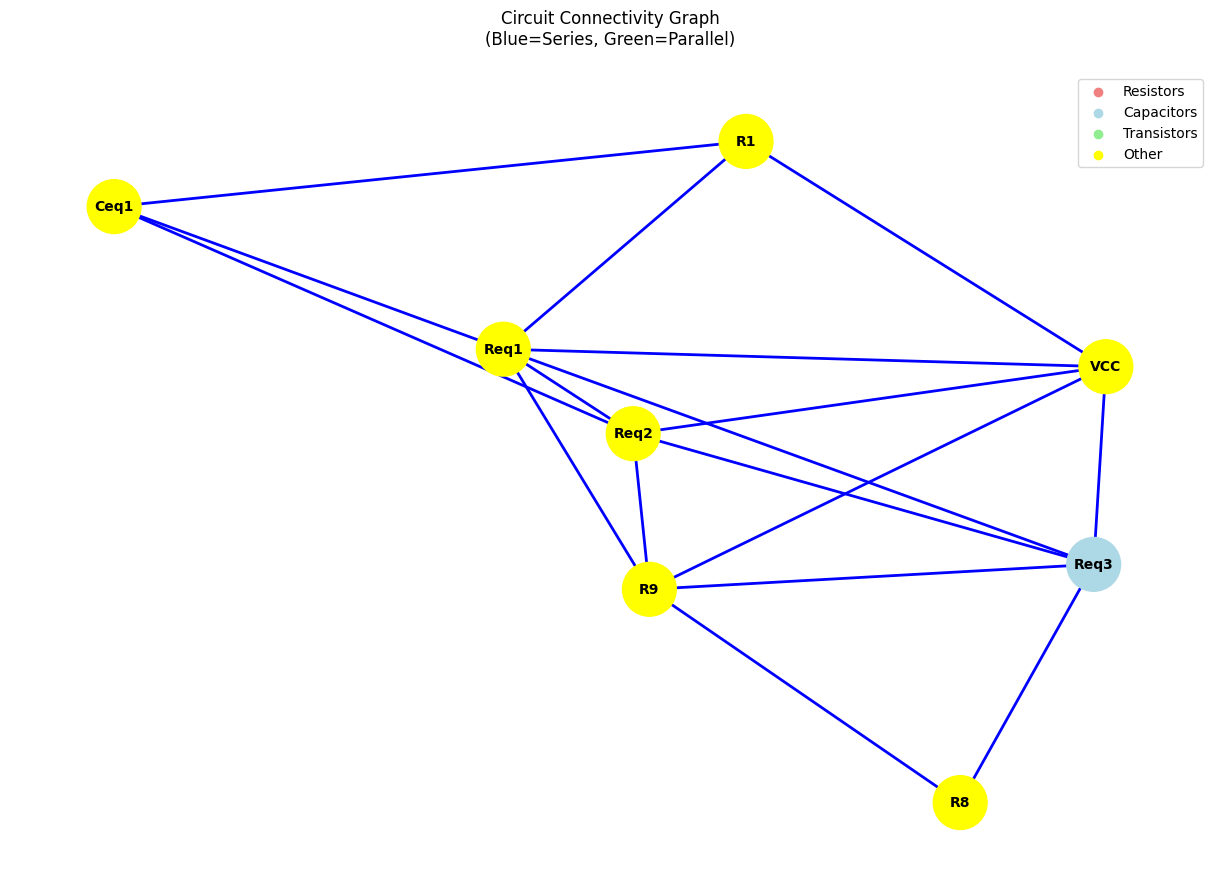

In [ ]:
import re

def parse_value(value_str):
    multipliers = {'k': 1e3, 'm': 1e-3, 'u': 1e-6, 'n': 1e-9, 'p': 1e-12}
    match = re.match(r'^([\d.]+)([a-zA-Z]*)$', value_str)
    if match:
        num, suffix = match.groups()
        return float(num) * multipliers.get(suffix.lower(), 1)
    else:
        # If value_str isn't a numeric value (like "NPN"), return None
        return None

def simplify_parallel_components(components, node_to_components, netlist_lines):
    comp_values = {}
    comp_lines = {line.split()[0]: line for line in netlist_lines}

    # Extract component values
    for comp, line in comp_lines.items():
      value = line.strip().split()[-1]
      parsed_val = parse_value(value)
      if parsed_val is not None:
          comp_values[comp] = parsed_val

    # Build a reverse map: (node1, node2, type) -> [components]
    parallel_groups = defaultdict(list)

    for comp, nodes in components.items():
        if len(nodes) == 2:
            n1, n2 = sorted(nodes)
            key = (n1, n2, comp[0])  # R, C, L
            parallel_groups[key].append(comp)

    new_components = {}
    removed_components = set()
    new_netlist = []

    counter = {'R': 1, 'C': 1, 'L': 1}

    for (n1, n2, ctype), group in parallel_groups.items():
        if len(group) > 1:
            # Simplify
            if ctype == 'R':
                req = 1 / sum(1 / comp_values[c] for c in group)
                name = f"Req{counter['R']}"
                counter['R'] += 1
                value = f"{req:.2f}"
            elif ctype == 'C':
                ceq = sum(comp_values[c] for c in group)
                name = f"Ceq{counter['C']}"
                counter['C'] += 1
                value = f"{ceq:.2e}"
            elif ctype == 'L':
                leq = 1 / sum(1 / comp_values[c] for c in group)
                name = f"Leq{counter['L']}"
                counter['L'] += 1
                value = f"{leq:.2e}"
            else:
                continue

            # Replace
            new_components[name] = [n1, n2]
            for node in [n1, n2]:
                node_to_components[node].add(name)
                node_to_components[node] -= set(group)

            removed_components.update(group)
            new_netlist.append(f"{name} {n1} {n2} {value}")
        else:
          comp = group[0]
          new_components[comp] = components[comp]
          if comp in comp_lines:
            new_netlist.append(comp_lines[comp])

        # Print summary of simplifications
    print("\nSimplified Parallel Components:")
    for (n1, n2, ctype), group in parallel_groups.items():
        if len(group) > 1:
            if ctype == 'R':
                name = f"Req{counter['R'] - 1}"
            elif ctype == 'C':
                name = f"Ceq{counter['C'] - 1}"
            elif ctype == 'L':
                name = f"Leq{counter['L'] - 1}"
            else:
                continue
            print(f"  {', '.join(group)} → {name} (nodes: {n1}, {n2})")

    return new_components, node_to_components, new_netlist



# Then simplify the circuit by combining parallel Rs, Cs, Ls
components, node_to_components, simplified_netlist = simplify_parallel_components(
    components, node_to_components, test_netlist
)

# Now build and draw the graph from the simplified version
G = build_connectivity_graph(components, node_to_components)
draw_connectivity_graph(G)